<a href="https://colab.research.google.com/github/LJMfintech/Financial_Data_Analysis/blob/main/DataAnalysisHW1_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wrds
!pip install numpy_financial

In [ ]:
# 코드를 작성하는데 필요한 도구들 끌어오기
import wrds
import numpy_financial as npf
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [ ]:
# WRDS 연결
conn = wrds.Connection()

Enter your WRDS username [root]:leeskku2025
Enter your password:··········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


# 1번 문제 (Data Collection)

Global Compustat에서 월별 기업 단위 데이터를 수집하기 위해 WRDS ‘comp' 라이브러리에서 'g_secm' 테이블을 사용하여 필요한 정보들을 ’month_data_set'에 저장하였습니다. 하지만, 'g_secm' 테이블의 Column을 확인해본 결과 2번 문제에서 필요한 변수 중 하나인 ’cshoi' (총 발행 주식 수)를 포함하지 않고 있어 기업의 회계 기초 자료들을 포함하고 있는 ‘g_funda' 테이블에서 ’cshoi' 변수만 추출하였습니다.

 이후에는 데이터 클리닝 과정을 통해 데이터의 결측치를 줄이고 데이터 병합 과정을 통해 ‘cshoi_data_set과 ‘month_data_set'을 병합하여 1번 문제에서 요구하는 데이터를 포함한 'data_set'을 만들었습니다.


In [ ]:
# WRDS에 있는 리스트 확인
lib_list = conn.list_libraries()
print(type(lib_list))
print(lib_list)

<class 'list'>
['aha_sample', 'ahasamp', 'audit', 'audit_audit_comp', 'audit_common', 'auditsmp', 'auditsmp_all', 'bank', 'bank_all', 'bank_premium_samp', 'banksamp', 'block', 'block_all', 'boardex_trial', 'boardsmp', 'bvd_amadeus_trial', 'bvd_bvdbankf_trial', 'bvd_orbis_trial', 'bvdsamp', 'calcbench_trial', 'calcbnch', 'candid_samp', 'cboe', 'cboe_all', 'cboe_sample', 'cboesamp', 'cddsamp', 'ciq', 'ciq_capstrct', 'ciq_common', 'ciqsamp', 'ciqsamp_capstrct', 'ciqsamp_common', 'ciqsamp_keydev', 'ciqsamp_pplintel', 'ciqsamp_ratings', 'ciqsamp_transactions', 'ciqsamp_transcripts', 'cisdmsmp', 'columnar', 'comp', 'comp_execucomp', 'comp_global_daily', 'comp_na_daily_all', 'compsamp', 'compsamp_all', 'compsamp_snapshot', 'contrib', 'contrib_as_filed_financials', 'contrib_ceo_turnover', 'contrib_char_returns', 'contrib_corporate_culture', 'contrib_general', 'contrib_global_factor', 'contrib_intangible_value', 'contrib_kpss', 'contrib_liva', 'crsp', 'crsp_a_indexes', 'crsp_a_stock', 'crsp_a_t

In [ ]:
# comp 카테고리하위 리스트 확인.
conn.list_tables(library='comp')

['aco_amda',
 'aco_imda',
 'aco_indfnta',
 'aco_indfntq',
 'aco_indfntytd',
 'aco_indsta',
 'aco_indstq',
 'aco_indstytd',
 'aco_notesa',
 'aco_notesq',
 'aco_notessa',
 'aco_notesytd',
 'aco_pnfnda',
 'aco_pnfndq',
 'aco_pnfndytd',
 'aco_pnfnta',
 'aco_pnfntq',
 'aco_pnfntytd',
 'aco_transa',
 'aco_transq',
 'aco_transsa',
 'aco_transytd',
 'adsprate',
 'asec_amda',
 'asec_imda',
 'asec_notesa',
 'asec_notesq',
 'asec_transa',
 'asec_transq',
 'bank_aacctchg',
 'bank_adesind',
 'bank_afnd1',
 'bank_afnd2',
 'bank_afnddc1',
 'bank_afnddc2',
 'bank_afntind',
 'bank_funda',
 'bank_funda_fncd',
 'bank_fundq',
 'bank_fundq_fncd',
 'bank_iacctchg',
 'bank_idesind',
 'bank_ifndq',
 'bank_ifndytd',
 'bank_ifntq',
 'bank_ifntytd',
 'bank_names',
 'bank_namesq',
 'chars',
 'co_aacctchg',
 'co_aaudit',
 'co_acthist',
 'co_adesind',
 'co_adjfact',
 'co_afnd1',
 'co_afnd2',
 'co_afnddc1',
 'co_afnddc2',
 'co_afntind1',
 'co_afntind2',
 'co_ainvval',
 'co_amkt',
 'co_busdescl',
 'co_cotype',
 'co_f

In [ ]:
# comp 하위 리스트중 g_secm에서 이후의 문제들을 해결할 때 필요한 변수들을 가장 많이 포함하고 있다고 생각해 'g_secm' 테이블 선정
test1 = conn.get_table(library='comp', table='g_funda', obs = 5)
test1

,gvkey,indfmt,datafmt,consol,popsrc,acctstd,acqmeth,bspr,compst,curcd,...,tstkni,conm,costat,fic,loc,naicsh,sich,rank,au,auop
0,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,NLG,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
1,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,NLG,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
2,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,NLG,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
3,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,EUR,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
4,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,EUR,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1


In [ ]:
# 2번 문제에서 필요한 변수 중 하나인 'cshoi'를 포함하고 있는 'g_funda' 테이블 선정
test2 = conn.get_table(library='comp', table='g_funda', obs = 5)
test2

,gvkey,indfmt,datafmt,consol,popsrc,acctstd,acqmeth,bspr,compst,curcd,...,tstkni,conm,costat,fic,loc,naicsh,sich,rank,au,auop
0,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,NLG,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
1,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,NLG,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
2,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,NLG,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
3,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,EUR,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1
4,001166,INDL,HIST_STD,C,I,DS,<NA>,GO,<NA>,EUR,...,0.0,ASM INTERNATIONAL NV,A,NLD,NLD,333295,3559,1,5,1


In [ ]:
# 총 발행 주식 수 추출
cshoi_data_set = conn.raw_sql("""select gvkey, datadate, cshoi

                          from comp.g_funda
                          where fic IN('GBR', 'DEU', 'JPN', 'FRA', 'AUS', 'CHN', 'IND', 'BRA', 'ZAF', 'TUR')
                          and datadate between '2020-03-01' and '2024-12-31'
                          """)
print(cshoi_data_set.shape)

(105522, 3)


In [ ]:
# 월별 데이터 추출

month_data_set = conn.raw_sql("""select gvkey, iid, datadate, ajexm, ajpm, cshtrm, prccm, prchm, prclm, dvpspm, dvpsxm, fic, loc

                          from comp.g_secm
                          where fic IN('GBR', 'DEU', 'JPN', 'FRA', 'AUS', 'CHN', 'IND', 'BRA', 'ZAF', 'TUR')
                          and datadate between '2020-03-01' and '2024-12-31'
                          """)
print(month_data_set.shape)

(1546685, 13)


데이터 클리닝

In [ ]:

# inf, -inf를 NaN으로 변환
cshoi_data_set = cshoi_data_set.replace([np.inf, -np.inf], np.nan)

# Drop the rows containing NA
cshoi_data_set= cshoi_data_set.dropna(axis=0) # NA값 있는 행 삭제

print(cshoi_data_set.shape)


# inf, -inf를 NaN으로 변환
month_data_set = month_data_set.replace([np.inf, -np.inf], np.nan)

# Drop the rows containing NA
month_data_set= month_data_set.dropna(axis=0) # NA값 있는 행 삭제

print(month_data_set.shape)


(96278, 3)
(1361150, 13)


In [ ]:
# 결측치 검사
print('Null Values =', cshoi_data_set.isnull().values.any())
print('Null Values =', month_data_set.isnull().values.any())

Null Values = False
Null Values = False


데이터 병합

In [ ]:
import pandas as pd

# 월간 데이터의 'datadate'에서 연도 추출 후 컬럼 추가
month_data_set['year'] = pd.to_datetime(month_data_set['datadate']).dt.year

# 연간 데이터도 'datadate'의 연도 추출하여 year 컬럼 생성
cshoi_data_set['year'] = pd.to_datetime(cshoi_data_set['datadate']).dt.year

# gvkey, fic, year 세 컬럼 기준으로 병합
data_set = pd.merge(month_data_set, cshoi_data_set, on=['gvkey', 'year'], how='left')

# 필요 없는 컬럼 삭제
data_set = data_set.drop(columns=['datadate_y', 'year'])

# datadate_x 컬럼 이름을 datadate로 변경
data_set = data_set.rename(columns={'datadate_x': 'datadate'})

# 결과 확인
print(data_set.head())

    gvkey  iid    datadate  ajexm  ajpm      cshtrm   prccm   prchm   prclm  \
0  001932  01W  2020-03-31    1.0   1.0  167128.582   27.59  32.445   23.82   
1  001932  02W  2020-03-31    1.0   1.0   38145.786  598.66  645.17   498.0   
2  001932  03W  2020-03-31    1.0   1.0      57.605   30.98  37.265   25.65   
3  001932  04W  2020-03-31    1.0   1.0   23539.937  27.385   32.53  23.685   
4  002410  01W  2020-03-31    1.0   1.0  2421381.88   3.442  4.2265   2.337   

   dvpspm  dvpsxm  fic  loc      cshoi  
0     0.0   0.526  GBR  GBR   2288.191  
1     0.0  10.789  GBR  GBR   2288.191  
2     0.0   0.579  GBR  GBR   2288.191  
3     0.0   0.526  GBR  GBR   2288.191  
4   0.082     0.0  GBR  GBR  20262.135  


# 2번 문제 (Return Generating Process)

문제에서 요구하는 시장가치와 월별 수익률을 계산하기 위해 조정계수와 날짜들을 조정한 이후,

a)
1. 조정주가 ['prccm_adj'] = 원래 주가 ['prccm'] * 조정계수 ['ajpm'] / ['ajexm']
2. 이전 조정주가 ['prccm_adj_prev'] = 이전 시점의 조정주가 ['prccm_adj'].shift(1)
3. 수익률 ['ret'] = (현재 조정주가 ['prccm_adj'] / 이전조정주가 ['prccm_adj_prev']) - 1

의 방식으로 기업 단위 월별 주식 수익률을 구하였고,

b)

시가총액 ['mktcap'] = 조정주가 ['prccm_adj'] * 발행주식수 ['cshoi']

의 방식으로 기업 단위 시장가치를 계산하였으며,

c)

ew_ret 공식과 vw_ret 공식을 이용하여 국가 단위 월별 수익률을 구하였습니다. 국가 단위 ew 수익률과 vw 수익률은 데이터 시각화를 이용하여 그래프로 표현하였습니다.





In [ ]:

# -----------------------------
# 1. 조정계수 처리
# -----------------------------
# ajexm 처리
if 'ajexm' in data_set.columns:
    data_set['ajexm'] = data_set['ajexm'].replace(0, np.nan)
    if data_set['ajexm'].isna().any():
      data_set['ajexm'] = data_set['ajexm'].fillna(1)
else:
    data_set['ajexm'] = 1

# ajpm 처리
if 'ajpm' in data_set.columns:
    data_set['ajpm'] = data_set['ajpm'].replace(0, np.nan).fillna(1)
else:
    data_set['ajpm'] = 1

# -----------------------------
# 2. 날짜 처리 및 정렬
# -----------------------------
data_set['datadate'] = pd.to_datetime(data_set['datadate'], errors='coerce')
invalid_dates = data_set['datadate'].isna().sum()
data_set = data_set.dropna(subset=['datadate'])  # 날짜 NaT 제거
data_set = data_set.sort_values(['gvkey', 'datadate'])

# -----------------------------
# 3. 조정주가 및 수익률 계산
# -----------------------------
data_set['prccm_adj'] = data_set['prccm'] * (data_set['ajpm'] / data_set['ajexm'])
data_set['prccm_adj_prev'] = data_set.groupby('gvkey')['prccm_adj'].shift(1)
data_set['ret'] = data_set['prccm_adj'] / data_set['prccm_adj_prev'] - 1

# 수익률 이상치 필터 (절대값 1.5 초과 시 제거)
data_set.loc[data_set['ret'].abs() > 1.5, 'ret'] = np.nan

# -----------------------------
# 4. 시가총액 계산
# -----------------------------
if 'cshoi' in data_set.columns:
    data_set['mktcap'] = data_set['prccm_adj'] * data_set['cshoi']
else:
    data_set['mktcap'] = np.nan

# -----------------------------
# 5. 결측 및 이상치 처리
# -----------------------------
data_set = data_set.replace([np.inf, -np.inf], np.nan)
data_set = data_set.dropna(subset=['ret', 'mktcap', 'datadate'])

# -----------------------------
# 6. 동등가중 수익률 계산
# -----------------------------
# ret 유효값이 2개 이상인 그룹만 계산
def calc_ew_avg(x):
    valid_ret = x['ret'].dropna()
    if len(valid_ret) >= 2:
        return valid_ret.mean()
    else:
        return np.nan

ew_ret = data_set.groupby(['fic', 'datadate']).apply(calc_ew_avg).reset_index(name='ew_ret')
ew_ret = ew_ret.dropna(subset=['ew_ret'])

# -----------------------------
# 7. 시가총액가중 수익률 계산
# -----------------------------
def calc_vw_avg(x):
    valid = (x['mktcap'] > 0) & x['ret'].notna()
    if valid.any():
        return np.average(x.loc[valid, 'ret'], weights=x.loc[valid, 'mktcap'])
    else:
        return np.nan

vw_ret = data_set.groupby(['fic', 'datadate']).apply(calc_vw_avg).reset_index(name='vw_ret')
vw_ret = vw_ret.dropna(subset=['vw_ret'])

# -----------------------------
# 8. 최종 정렬 및 확인
# -----------------------------
ew_ret = ew_ret.sort_values('datadate').reset_index(drop=True)
vw_ret = vw_ret.sort_values('datadate').reset_index(drop=True)

print("동등가중 수익률 샘플:")
print(ew_ret.head())

print("시가총액가중 수익률 샘플:")
print(vw_ret.head())

/tmp/ipython-input-3737623753.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ew_ret = data_set.groupby(['fic', 'datadate']).apply(calc_ew_avg).reset_index(name='ew_ret')


동등가중 수익률 샘플:
   fic   datadate    ew_ret
0  AUS 2020-03-31 -0.363848
1  CHN 2020-03-31 -0.000695
2  DEU 2020-03-31   -0.0292
3  FRA 2020-03-31 -0.024308
4  GBR 2020-03-31 -0.001958
시가총액가중 수익률 샘플:
   fic   datadate    vw_ret
0  AUS 2020-03-31 -0.255902
1  CHN 2020-03-31  0.007591
2  DEU 2020-03-31 -0.046432
3  FRA 2020-03-31 -0.012695
4  ZAF 2020-03-31  0.042781


/tmp/ipython-input-3737623753.py:74: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_ret = data_set.groupby(['fic', 'datadate']).apply(calc_vw_avg).reset_index(name='vw_ret')


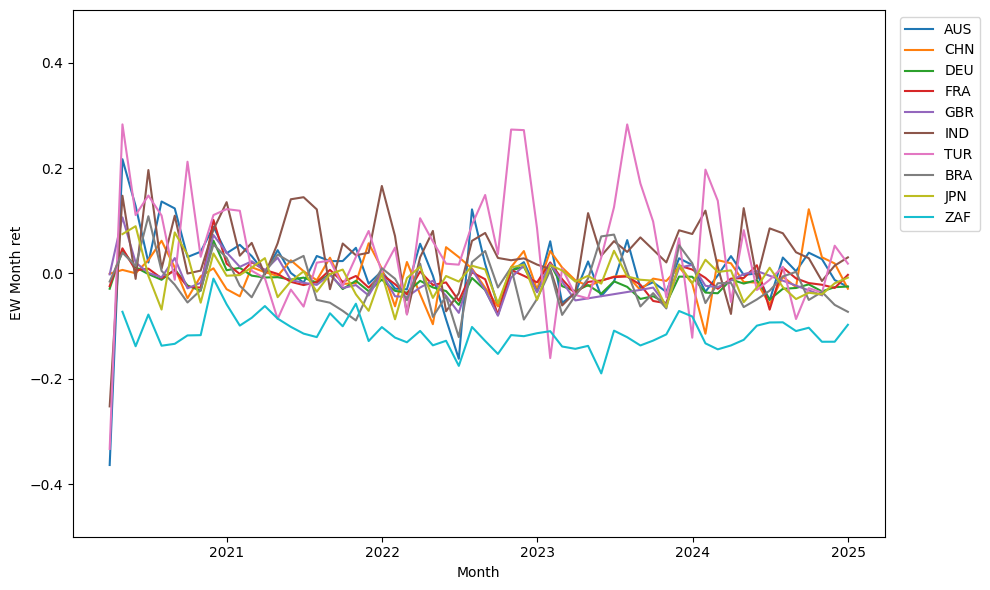

In [ ]:
# datadate가 날짜형이면 변환, 아니면 생략
ew_ret['datadate'] = pd.to_datetime(ew_ret['datadate'], errors='coerce')

# 0.5 이상/이하 극단값 제외한 데이터만 선택
plot_data = ew_ret[ew_ret['ew_ret'].abs() < 0.5]

plt.figure(figsize=(10,6))
for fic in plot_data['fic'].unique():
    temp = plot_data[plot_data['fic'] == fic]
    plt.plot(temp['datadate'], temp['ew_ret'], label=fic)
plt.ylim(-0.5, 0.5)           # y축 제한 필요하면 조정(극단값이 이미 제거되어 -0.2~0.2로 주로 사용)
plt.ylabel("EW Month ret")
plt.xlabel("Month")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)
plt.tight_layout()
plt.show()


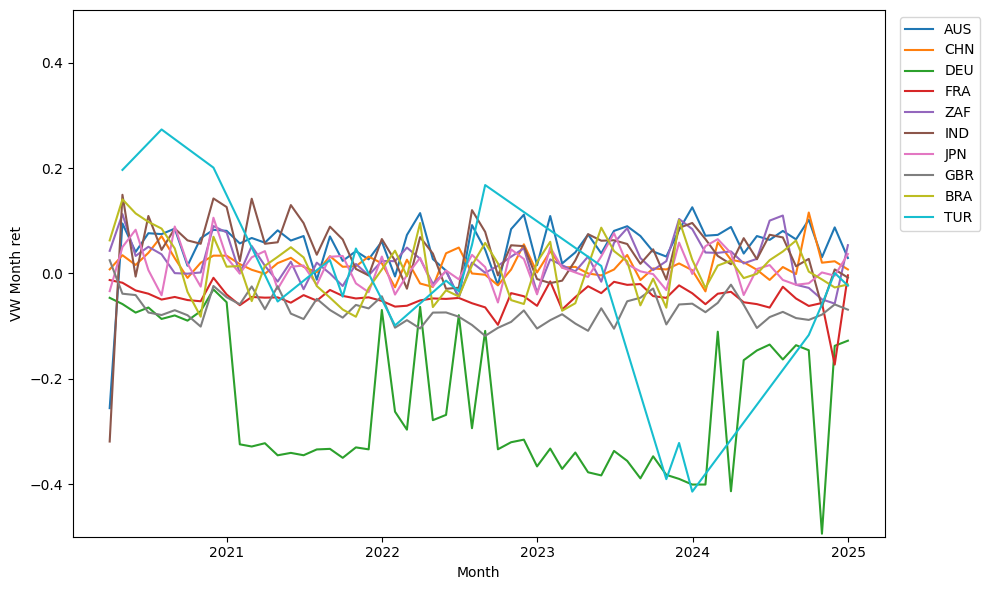

In [ ]:
# datadate가 날짜형이면 변환
vw_ret['datadate'] = pd.to_datetime(vw_ret['datadate'], errors='coerce')

# 극단치 제거: VW 수익률이 -0.2~0.2 범위만 사용
plot_data = vw_ret[vw_ret['vw_ret'].abs() < 0.5]

plt.figure(figsize=(10,6))
for fic in plot_data['fic'].unique():
    temp = plot_data[plot_data['fic'] == fic]
    plt.plot(temp['datadate'], temp['vw_ret'], label=fic)
plt.ylim(-0.5, 0.5)           # y축 제한 필요하면 조정(극단값이 이미 제거되어 -0.2~0.2로 주로 사용)
plt.ylabel("VW Month ret")
plt.xlabel("Month")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2)
plt.tight_layout()
plt.show()

# 3번 문제 (Period Definition)

2번 문제에서 구한 ew_ret와 vw_ret 데이터셋에

2020/03/01 ~ 2021/12/31: COVID-19 Crisis Period

2022/01/01 ~ 2024/12/31: Post-crisis Recovery Period

로 나누어 'period' Column을 추가해서 구분하였습니다.

In [ ]:
# 새 컬럼 period 생성 함수
def classify_period(date):
    if pd.Timestamp('2020-03-01') <= date <= pd.Timestamp('2021-12-31'):
        return 'COVID-19 Crisis Period'
    elif pd.Timestamp('2022-01-01') <= date <= pd.Timestamp('2024-12-31'):
        return 'Post-crisis Recovery Period'
    else:
        return 'Other'

#  period 컬럼 생성
data_set['period'] = data_set['datadate'].apply(classify_period)

ew_ret['period'] = ew_ret['datadate'].apply(classify_period)
vw_ret['period'] = vw_ret['datadate'].apply(classify_period)

# 결과 예시
print(ew_ret.head())
print(vw_ret.head())
print(ew_ret.tail())
print(vw_ret.tail())

   fic   datadate    ew_ret                  period
0  AUS 2020-03-31 -0.363848  COVID-19 Crisis Period
1  CHN 2020-03-31 -0.000695  COVID-19 Crisis Period
2  DEU 2020-03-31   -0.0292  COVID-19 Crisis Period
3  FRA 2020-03-31 -0.024308  COVID-19 Crisis Period
4  GBR 2020-03-31 -0.001958  COVID-19 Crisis Period
   fic   datadate    vw_ret                  period
0  AUS 2020-03-31 -0.255902  COVID-19 Crisis Period
1  CHN 2020-03-31  0.007591  COVID-19 Crisis Period
2  DEU 2020-03-31 -0.046432  COVID-19 Crisis Period
3  FRA 2020-03-31 -0.012695  COVID-19 Crisis Period
4  ZAF 2020-03-31  0.042781  COVID-19 Crisis Period
     fic   datadate    ew_ret                       period
564  FRA 2024-12-31 -0.002827  Post-crisis Recovery Period
565  IND 2024-12-31   0.03034  Post-crisis Recovery Period
566  JPN 2024-12-31 -0.008064  Post-crisis Recovery Period
567  BRA 2024-12-31 -0.073026  Post-crisis Recovery Period
568  ZAF 2024-12-31 -0.097649  Post-crisis Recovery Period
     fic   datadate   

# 4번 문제 (Summary Statistics by Country and Period)

문제에서 요구하는 통계량들을 calc_summary_stats 함수에 정의한 다음, ew_ret와 vw_ret에 적용하여 계산을 하였습니다.



In [ ]:
from scipy.stats import skew, kurtosis


# summary statistics 함수 정의
def calc_summary_stats(x):
    return pd.Series({
        'mean': x.mean(),
        'median': x.median(),
        'std': x.std(),
        'min': x.min(),
        'max': x.max(),
        'autocorr': x.autocorr(lag=1),
        'skewness': skew(x.dropna()),
        'excess_kurtosis': kurtosis(x.dropna(), fisher=True)
    })



# [여기서부터 추가]
ew_ret['ew_ret'] = pd.to_numeric(ew_ret['ew_ret'], errors='coerce')
vw_ret['vw_ret'] = pd.to_numeric(vw_ret['vw_ret'], errors='coerce')

# 국가별, 기간별 그룹 요약통계 산출
ew_stats = ew_ret.groupby(['fic', 'period'])['ew_ret'].apply(calc_summary_stats).reset_index()
vw_stats = vw_ret.groupby(['fic', 'period'])['vw_ret'].apply(calc_summary_stats).reset_index()


# 결과 출력
print(ew_stats)
print(vw_stats)



     fic                       period          level_2    ew_ret
0    AUS       COVID-19 Crisis Period             mean  0.031236
1    AUS       COVID-19 Crisis Period           median  0.032834
2    AUS       COVID-19 Crisis Period              std  0.105000
3    AUS       COVID-19 Crisis Period              min -0.363848
4    AUS       COVID-19 Crisis Period              max  0.216654
..   ...                          ...              ...       ...
155  ZAF  Post-crisis Recovery Period              min -0.189928
156  ZAF  Post-crisis Recovery Period              max -0.071437
157  ZAF  Post-crisis Recovery Period         autocorr  0.208668
158  ZAF  Post-crisis Recovery Period         skewness -0.465263
159  ZAF  Post-crisis Recovery Period  excess_kurtosis  0.996945

[160 rows x 4 columns]
     fic                       period          level_2    vw_ret
0    AUS       COVID-19 Crisis Period             mean  0.043987
1    AUS       COVID-19 Crisis Period           median  0.064464
2

In [ ]:
# CSV 파일로 저장
ew_stats.to_csv('ew_stats.csv', index=False)
vw_stats.to_csv('vw_stats.csv', index=False)

# 5번 문제 (Comparative Analysis)

선진국과 신흥국을 각각 developed와 emerging으로 분류한 다음, ew_ret와 vw_ret 데이터셋에도 분류를 하였습니다. 이후에는 위의 4번 문제에서 선언한 calc_summary_stats 함수를 이용하여 그룹간 통계량을 구하였습니다.


In [ ]:
# 국가 그룹 분류 컬럼 추가 ("developed"/"emerging")
developed = ['GBR', 'DEU', 'JPN', 'FRA', 'AUS']
emerging = ['CHN', 'IND', 'BRA', 'ZAF', 'TUR']

ew_ret['group'] = ew_ret['fic'].apply(lambda x: 'developed' if x in developed else ('emerging' if x in emerging else 'other'))
vw_ret['group'] = vw_ret['fic'].apply(lambda x: 'developed' if x in developed else ('emerging' if x in emerging else 'other'))

# 숫자형 변환
ew_ret['ew_ret'] = pd.to_numeric(ew_ret['ew_ret'], errors='coerce')
vw_ret['vw_ret'] = pd.to_numeric(vw_ret['vw_ret'], errors='coerce')

# 국가그룹, 기간별 요약통계 산출
ew_stats_group = ew_ret.groupby(['group', 'period'])['ew_ret'].apply(calc_summary_stats).reset_index()
vw_stats_group = vw_ret.groupby(['group', 'period'])['vw_ret'].apply(calc_summary_stats).reset_index()

# 결과 출력
print(ew_stats_group)
print(vw_stats_group)

        group                       period          level_2     ew_ret
0   developed       COVID-19 Crisis Period             mean   0.000974
1   developed       COVID-19 Crisis Period           median  -0.000804
2   developed       COVID-19 Crisis Period              std   0.084942
3   developed       COVID-19 Crisis Period              min  -0.660729
4   developed       COVID-19 Crisis Period              max   0.216654
5   developed       COVID-19 Crisis Period         autocorr   0.071995
6   developed       COVID-19 Crisis Period         skewness  -4.773972
7   developed       COVID-19 Crisis Period  excess_kurtosis  34.878484
8   developed  Post-crisis Recovery Period             mean  -0.017282
9   developed  Post-crisis Recovery Period           median  -0.017112
10  developed  Post-crisis Recovery Period              std   0.032196
11  developed  Post-crisis Recovery Period              min  -0.162239
12  developed  Post-crisis Recovery Period              max   0.121431
13  de

In [ ]:
# CSV 파일로 저장
ew_stats_group.to_csv('ew_stats_group.csv', index=False)
vw_stats_group.to_csv('vw_stats_group.csv', index=False)

# 6번 문제 (Correlation and Spillover Effects)


In [ ]:
# --- ew_ret 기준 ---

# 코로나 시기
ew_ret_covid = ew_ret[ew_ret['period'] == 'COVID-19 Crisis Period']
pivot_covid_ew = ew_ret_covid.pivot(index='datadate', columns='fic', values='ew_ret')
corr_covid_ew = pivot_covid_ew.corr()

# 회복기 시기
ew_ret_recovery = ew_ret[ew_ret['period'] == 'Post-crisis Recovery Period']
pivot_recovery_ew = ew_ret_recovery.pivot(index='datadate', columns='fic', values='ew_ret')
corr_recovery_ew = pivot_recovery_ew.corr()

print("COVID-19 Crisis Period ew_ret 상관계수 행렬")
print(corr_covid_ew)
print("\nPost-crisis Recovery Period ew_ret 상관계수 행렬")
print(corr_recovery_ew)

# --- vw_ret 기준 ---

# 코로나 시기
vw_ret_covid = vw_ret[vw_ret['period'] == 'COVID-19 Crisis Period']
pivot_covid_vw = vw_ret_covid.pivot(index='datadate', columns='fic', values='vw_ret')
corr_covid_vw = pivot_covid_vw.corr()

# 회복기 시기
vw_ret_recovery = vw_ret[vw_ret['period'] == 'Post-crisis Recovery Period']
pivot_recovery_vw = vw_ret_recovery.pivot(index='datadate', columns='fic', values='vw_ret')
corr_recovery_vw = pivot_recovery_vw.corr()

print("COVID-19 Crisis Period vw_ret 상관계수 행렬")
print(corr_covid_vw)
print("\nPost-crisis Recovery Period vw_ret 상관계수 행렬")
print(corr_recovery_vw)

COVID-19 Crisis Period ew_ret 상관계수 행렬
fic       AUS       BRA       CHN       DEU       FRA       GBR       IND  \
fic                                                                         
AUS  1.000000  0.131329  0.057153  0.520906  0.420084  0.422085  0.598531   
BRA  0.131329  1.000000  0.261007  0.513215  0.442048  0.515593  0.426191   
CHN  0.057153  0.261007  1.000000 -0.013265  0.050490 -0.046486  0.057545   
DEU  0.520906  0.513215 -0.013265  1.000000  0.924685  0.883289  0.328387   
FRA  0.420084  0.442048  0.050490  0.924685  1.000000  0.837910  0.268207   
GBR  0.422085  0.515593 -0.046486  0.883289  0.837910  1.000000  0.221342   
IND  0.598531  0.426191  0.057545  0.328387  0.268207  0.221342  1.000000   
JPN  0.879128  0.100659 -0.050373  0.401367  0.328186  0.222236  0.714555   
TUR  0.792608  0.181072 -0.053759  0.462421  0.380167  0.331528  0.501140   
ZAF  0.786554  0.127463 -0.028673  0.410830  0.432293  0.221595  0.718689   

fic       JPN       TUR       ZAF  
f

In [ ]:
# 기준 리스트
# developed = ['GBR', 'DEU', 'JPN', 'FRA', 'AUS']
# emerging = ['CHN', 'IND', 'BRA', 'ZAF', 'TUR']

def get_group_corrmat(ret_df, value_col, group_list, period_name):
    subset = ret_df[(ret_df['fic'].isin(group_list)) & (ret_df['period'] == period_name)]
    pivot = subset.pivot(index='datadate', columns='fic', values=value_col)
    return pivot.corr()

def get_corr_level(corrmat):
    # 상관계수 행렬에서 대각선 제외하고 평균
    m = corrmat.values
    mask = ~np.eye(m.shape[0], dtype=bool)
    return np.nanmean(m[mask])

# 그룹, 시기별 상관계수 행렬 및 평균값 구하기
results = []
for group_name, group_list in zip(['developed', 'emerging'], [developed, emerging]):
    for period in ['COVID-19 Crisis Period', 'Post-crisis Recovery Period']:
        # ew_ret
        corrmat_ew = get_group_corrmat(ew_ret, 'ew_ret', group_list, period)
        mean_corr_ew = get_corr_level(corrmat_ew)
        results.append({'type':'ew_ret', 'group':group_name, 'period':period, 'mean_corr':mean_corr_ew})
        # vw_ret
        corrmat_vw = get_group_corrmat(vw_ret, 'vw_ret', group_list, period)
        mean_corr_vw = get_corr_level(corrmat_vw)
        results.append({'type':'vw_ret', 'group':group_name, 'period':period, 'mean_corr':mean_corr_vw})


results_df = pd.DataFrame(results)

# 결과 출력(표 형태)
print(results_df)

     type      group                       period  mean_corr
0  ew_ret  developed       COVID-19 Crisis Period   0.583988
1  vw_ret  developed       COVID-19 Crisis Period   0.142224
2  ew_ret  developed  Post-crisis Recovery Period   0.598578
3  vw_ret  developed  Post-crisis Recovery Period   0.100782
4  ew_ret   emerging       COVID-19 Crisis Period   0.285797
5  vw_ret   emerging       COVID-19 Crisis Period   0.257230
6  ew_ret   emerging  Post-crisis Recovery Period   0.042167
7  vw_ret   emerging  Post-crisis Recovery Period   0.053054


In [ ]:
# CSV 파일로 저장
corr_covid_ew.to_csv('corr_covid_ew.csv', index=False)
corr_recovery_ew.to_csv('corr_recovery_ew.csv', index=False)

corr_covid_vw.to_csv('corr_covid_vw.csv', index=False)
corr_recovery_vw.to_csv('corr_recovery_vw.csv', index=False)

# 7번 문제 (Presentation of Results)

In [ ]:

ew_ret['group'] = ew_ret['fic'].apply(lambda x: 'developed' if x in developed else ('emerging' if x in emerging else 'other'))
vw_ret['group'] = vw_ret['fic'].apply(lambda x: 'developed' if x in developed else ('emerging' if x in emerging else 'other'))

# 1. 국가별 통계
stats_by_country_ew = ew_ret.groupby(['fic'])['ew_ret'].apply(calc_summary_stats).reset_index()
stats_by_country_vw = vw_ret.groupby(['fic'])['vw_ret'].apply(calc_summary_stats).reset_index()

# 2. 기간별 통계
stats_by_period_ew = ew_ret.groupby(['period'])['ew_ret'].apply(calc_summary_stats).reset_index()
stats_by_period_vw = vw_ret.groupby(['period'])['vw_ret'].apply(calc_summary_stats).reset_index()

# 3. 그룹별 통계
stats_by_group_ew = ew_ret.groupby(['group'])['ew_ret'].apply(calc_summary_stats).reset_index()
stats_by_group_vw = vw_ret.groupby(['group'])['vw_ret'].apply(calc_summary_stats).reset_index()


In [ ]:
# CSV 파일로 저장
stats_by_country_ew.to_csv('stats_by_country_ew.csv', index=False)
stats_by_country_vw.to_csv('stats_by_country_vw.csv', index=False)

stats_by_period_ew.to_csv('stats_by_period_ew.csv', index=False)
stats_by_period_vw.to_csv('stats_by_period_vw.csv', index=False)

stats_by_group_ew.to_csv('stats_by_group_ew.csv', index=False)
stats_by_group_vw.to_csv('stats_by_group_vw.csv', index=False)

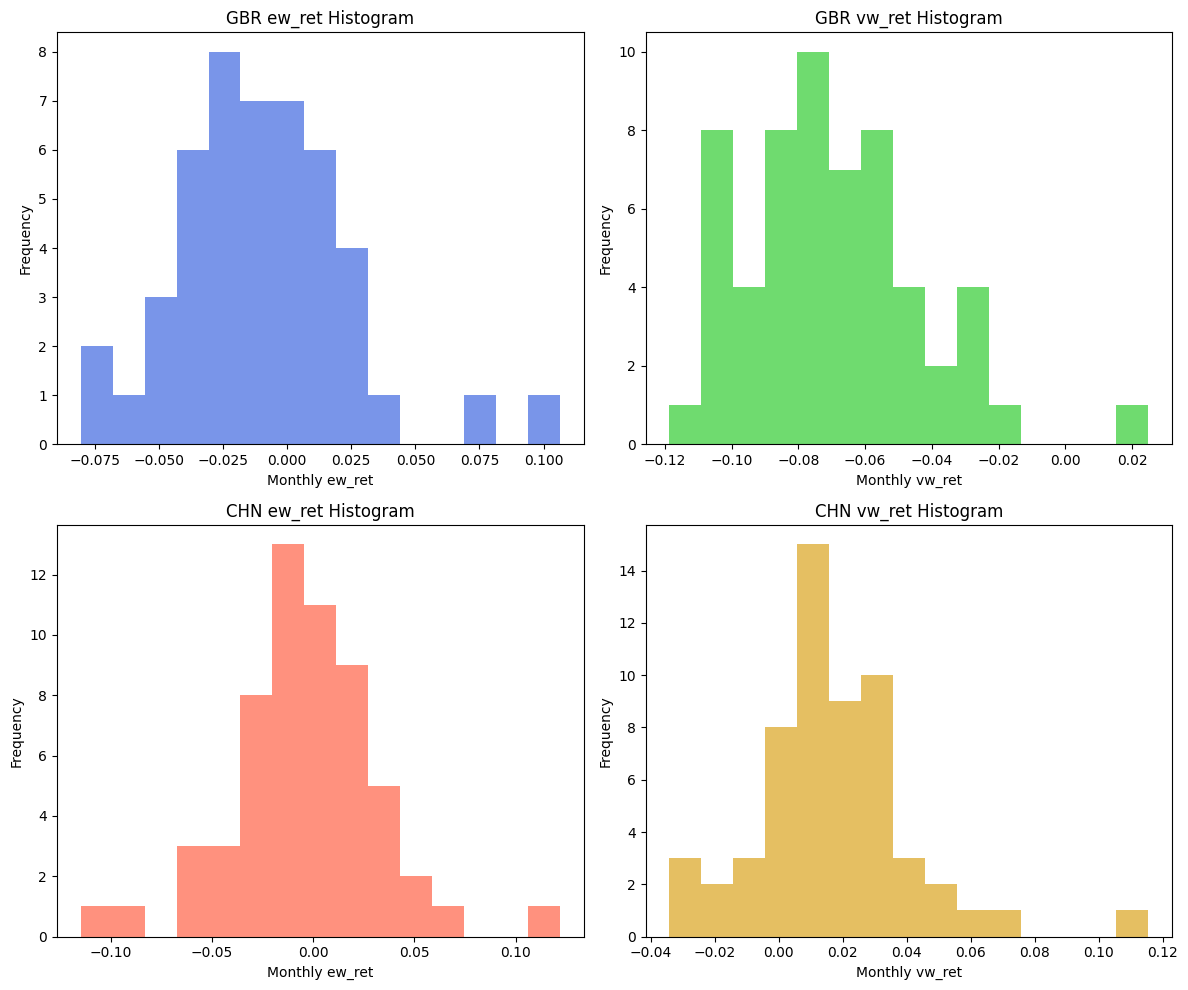

In [ ]:
# (b) GBR, CHN의 ew_ret/vw_ret 히스토그램 4구역 출력
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0,0].hist(ew_ret[ew_ret['fic']=='GBR']['ew_ret'].dropna(), bins=15, color='royalblue', alpha=0.7)
axs[0,0].set_title('GBR ew_ret Histogram')
axs[0,0].set_xlabel('Monthly ew_ret')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(vw_ret[vw_ret['fic']=='GBR']['vw_ret'].dropna(), bins=15, color='limegreen', alpha=0.7)
axs[0,1].set_title('GBR vw_ret Histogram')
axs[0,1].set_xlabel('Monthly vw_ret')
axs[0,1].set_ylabel('Frequency')

axs[1,0].hist(ew_ret[ew_ret['fic']=='CHN']['ew_ret'].dropna(), bins=15, color='tomato', alpha=0.7)
axs[1,0].set_title('CHN ew_ret Histogram')
axs[1,0].set_xlabel('Monthly ew_ret')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(vw_ret[vw_ret['fic']=='CHN']['vw_ret'].dropna(), bins=15, color='goldenrod', alpha=0.7)
axs[1,1].set_title('CHN vw_ret Histogram')
axs[1,1].set_xlabel('Monthly vw_ret')
axs[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()